In [8]:
from databaseCommunication import getNCount
from dataframeFormating import createLabeledDataFrame, fitRun_1and3b, fitRun_3b, getReducedDataframe, getReducedResults, deltaTime, N_polarized, N_polarized_pure3b
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

getNCount(94000)

84445.0

In [2]:
# [detuning, field direction], [imageID_start, imageID_end]
labels = [[['0.5GHz', 'Bz', 3], [94006, 94059]],
          [['0.5GHz', 'By', 3], [94060, 94113]]
         ]
excluded = []

In [4]:
#df = createLabeledDataFrame(labels)
#df['BECHoldTime'] = df['BECHoldTime'].astype(float)
#df.to_pickle('data_save_050321.pickle')

In [3]:
df = pd.read_pickle('data_save_050321.pickle')

# Delete these row indexes from dataFrame
indexNames = pd.Index(np.where(df['imageID'].isin(excluded))[0])
df.drop(indexNames, inplace = True)
df

,imageID,BECHoldTime,TOF,nCount,detuning,field_direction
0,94006.0,20.0,3,114693.0,0.5GHz,Bz
1,94007.0,60.0,3,73053.0,0.5GHz,Bz
2,94008.0,50.0,3,82843.0,0.5GHz,Bz
3,94009.0,30.0,3,101014.0,0.5GHz,Bz
4,94010.0,40.0,3,78678.0,0.5GHz,Bz
...,...,...,...,...,...,...
103,94109.0,80.0,3,47209.0,0.5GHz,By
104,94110.0,10.0,3,102835.0,0.5GHz,By
105,94111.0,70.0,3,62291.0,0.5GHz,By
106,94112.0,60.0,3,70255.0,0.5GHz,By


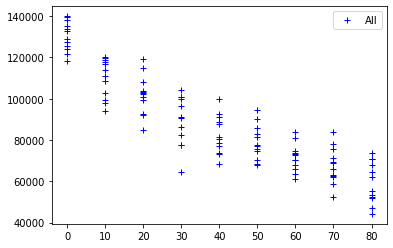

In [4]:
plt.figure()
plt.plot(df['BECHoldTime'], df['nCount'], '+', color = 'blue', label = 'All')
plt.legend()
plt.show()

#run = df[df['detuning'] == '0.5GHz']
#run1 = run[run['field_direction'] == 'Bz']
#run2 = run[run['field_direction'] == 'By']
#plt.figure()
#plt.plot(run1['BECHoldTime'], run1['nCount'], '+', color = 'blue', label = 'Bz')
#plt.plot(run2['BECHoldTime'], run2['nCount'], '+', color = 'red', label = 'By')
#plt.legend()
#plt.show()

We fit the polarized sample to $dN/dt = -\alpha N-\gamma N^{3}$, so $N(t) = \frac{\sqrt{\alpha}}{\sqrt{e^{2\alpha t}\left(\frac{a}{N(0)^{2}}+\gamma\right)-\gamma}}$ and the mixture one to $dN/dt = -\alpha N - \beta N^{2} -\gamma N^{3}$, so $N(t) = complicated$

In [5]:
results = []
for run in labels:
    detuning, field_direction, TOF = run[0]
    print(detuning, field_direction, TOF)
    popt, pcov = fitRun_1and3b(df, detuning, field_direction, TOF)
    results += [{'detuning' : detuning,
                        'TOF' : TOF,
                        'field_direction' : field_direction,
                        'N0' : popt[0],
                        'alpha' : popt[1],
                        'gamma' : popt[2]}]
resultsDF = pd.DataFrame(results)
print('\n')
print(resultsDF)
print('\n')
print(resultsDF['alpha']*resultsDF['N0']/(resultsDF['gamma']*(resultsDF['N0']**3)))
#perr = np.sqrt(np.diag(pcov))

0.5GHz Bz 3
0.5GHz By 3


  detuning  TOF field_direction             N0     alpha         gamma
0   0.5GHz    3              Bz  127922.819761  0.006481  1.777004e-13
1   0.5GHz    3              By  131433.302229  0.001635  1.283755e-12


0    2.228663
1    0.073707
dtype: float64


We notice the decay is nearly 3-body in all case. To ensure that we can look at $\alpha N_{0}/(\gamma*N_{0}^{3})$ which at $t=0$ is never above a 10\%. So let's just fit to a 3body decay curve.
$dN/dt = -\gamma N^{3}$, so $N(t) = \frac{N_{0}}{\sqrt{1+N_{0}^{2}\gamma t}}$.

In [6]:
results = []

for run in labels:
    detuning, field_direction, TOF = run[0]
    popt, pcov = fitRun_3b(df, detuning, field_direction, TOF)
    results += [{'detuning' : detuning,
                        'TOF' : TOF,
                        'field_direction' : field_direction,
                        'N0' : popt[0],
                        'gamma' : popt[1]}]
resultsDF_pure3b = pd.DataFrame(results)
resultsDF_pure3b
#perr = np.sqrt(np.diag(pcov))

,detuning,TOF,field_direction,N0,gamma
0,0.5GHz,3,Bz,131028.827443,1.713659e-12
1,0.5GHz,3,By,132199.355160,3.000413e-12


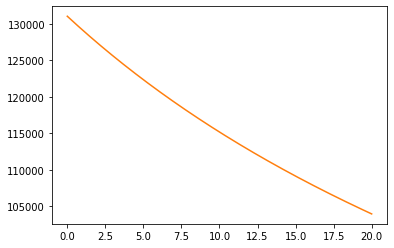

In [9]:
df_reduced = getReducedDataframe(df, detuning = '1GHz', field_direction = 'Bz', TOF = 3)
result_reduced = getReducedResults(resultsDF_pure3b, detuning = '0.5GHz', field_direction = 'Bz', TOF = 3)
holdTime = np.linspace(0,20, 300)
plt.figure()
plt.plot(df_reduced['BECHoldTime'], df_reduced['nCount'], '*')
plt.plot(holdTime, N_polarized_pure3b(holdTime, result_reduced['N0'][0], result_reduced['gamma'][0]))
plt.show()

Now we should look at how much time we should shift:

In [10]:
deltaTime(resultsDF_pure3b, '0.5GHz', 3)

0.0

Now we can calculate the ration of the beta, provided the derivative of the N_polarized_pure3b function: $\frac{dN}{dt} = -\frac{1}{2}N_{0}^{3}\gamma\left(1+N_{0}^{2}\gamma t\right)^{-3/2}$

In [11]:
def dN_polarized_pure3b_dt(t, N0, gamma):
    return -0.5*N0**3*gamma*(1+N0**2*gamma*t)**(-3/2)

def getBeta(results, detuning, field_direction, TOF):
    temp = results[results['detuning'] == detuning]
    temp = temp[temp['TOF'] == TOF]
    return temp[temp['field_direction'] == field_direction]['gamma']

results_betaRatio = []
for detuning in ['0.5GHz']:
    for TOF in [3]:
        print(detuning, TOF)
        beta_y_init = getBeta(resultsDF_pure3b, detuning, 'By', TOF)
        beta_z_init = getBeta(resultsDF_pure3b, detuning, 'Bz', TOF)
        #dt = deltaTime(resultsDF_pure3b, detuning, TOF)
        
        results_By = getReducedResults(resultsDF_pure3b, detuning, 'By', TOF)
        results_Bz = getReducedResults(resultsDF_pure3b, detuning, 'Bz', TOF)
        N0_y, gamma_y = results_By['N0'].iloc[0], results_By['gamma'].iloc[0]
        N0_z, gamma_z = results_Bz['N0'].iloc[0], results_Bz['gamma'].iloc[0]
        
        beta_y = dN_polarized_pure3b_dt(0, N0_y, gamma_y)
        #beta_z = dN_polarized_pure3b_dt(dt, N0_z, gamma_z)
        beta_z = dN_polarized_pure3b_dt(0, N0_z, gamma_z)
        
        results_betaRatio += [{'detuning' : detuning,
                        'TOF' : TOF,
                        'betaRatio' : beta_z/beta_y}]

results_betaRatio = pd.DataFrame(results_betaRatio)

results_betaRatio

0.5GHz 3


,detuning,TOF,betaRatio
0,0.5GHz,3,0.556104


In [12]:
detuning = '0.5GHz'
TOF = 3
beta_y_init = getBeta(resultsDF_pure3b, detuning, 'By', TOF)  # this is the gamma from the fit
beta_z_init = getBeta(resultsDF_pure3b, detuning, 'Bz', TOF)
dt = deltaTime(resultsDF_pure3b, detuning, TOF)

results_By = getReducedResults(resultsDF_pure3b, detuning, 'By', TOF)  # this is the full results of a fit
results_Bz = getReducedResults(resultsDF_pure3b, detuning, 'Bz', TOF)
N0_y, gamma_y = results_By['N0'].iloc[0], results_By['gamma'].iloc[0]
N0_z, gamma_z = results_Bz['N0'].iloc[0], results_Bz['gamma'].iloc[0]
        
beta_y = dN_polarized_pure3b_dt(0, N0_y, gamma_y)
beta_z = dN_polarized_pure3b_dt(dt, N0_z, gamma_z)
#beta_z/beta_y
print(beta_y)
print(beta_z)


-3466.084040577111
-1927.502134381682


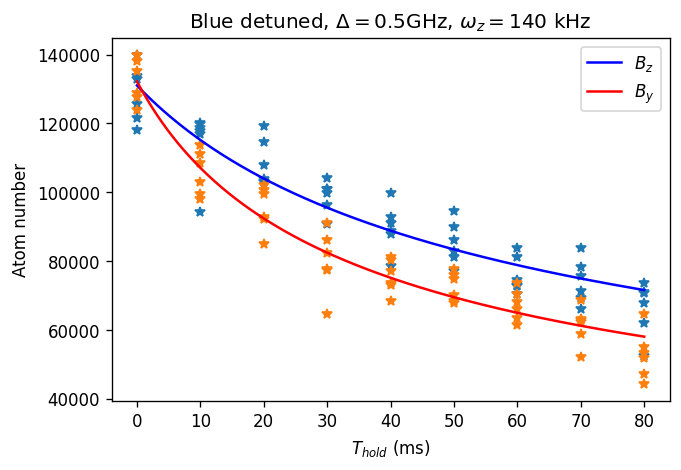

In [13]:
detuning = '0.5GHz'
TOF = 3
df_reduced_z = getReducedDataframe(df, detuning,'Bz', TOF)
df_reduced_y = getReducedDataframe(df, detuning,'By', TOF)
result_reduced_z = getReducedResults(resultsDF_pure3b, detuning, 'Bz', TOF)
result_reduced_y = getReducedResults(resultsDF_pure3b, detuning, 'By', TOF)

dNdt = dN_polarized_pure3b_dt(dt, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0])
holdTime = np.linspace(0,80, 300)
plt.figure(dpi = 120)
plt.plot(df_reduced_z['BECHoldTime'], df_reduced_z['nCount'], '*')
plt.plot(df_reduced_y['BECHoldTime'], df_reduced_y['nCount'], '*')
plt.plot(holdTime, N_polarized_pure3b(holdTime, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0]), color = 'blue', label = '$B_{z}$')
plt.plot(holdTime, N_polarized_pure3b(holdTime, result_reduced_y['N0'].iloc[0], result_reduced_y['gamma'].iloc[0]), color = 'red', label = '$B_{y}$')
plt.title('Blue detuned, $\Delta = 0.5$GHz, $\omega_{z} = 140$ kHz')
plt.legend()
plt.xlabel('$T_{hold}$ (ms)')
plt.ylabel('Atom number')
plt.show()

In [15]:
resultsDF_pure3b

,detuning,TOF,field_direction,N0,gamma
0,0.5GHz,3,Bz,131028.827443,1.713659e-12
1,0.5GHz,3,By,132199.355160,3.000413e-12


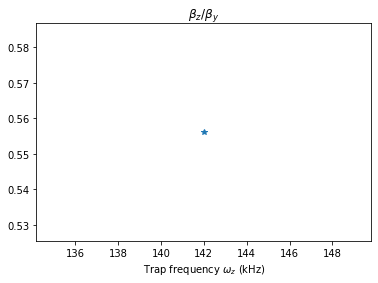

In [18]:
#points1G = results_betaRatio[results_betaRatio['detuning'] == '1GHz']['betaRatio']
#points15G = results_betaRatio[results_betaRatio['detuning'] == '1.5GHz']['betaRatio']
points05G = results_betaRatio[results_betaRatio['detuning'] == '0.5GHz']['betaRatio']
plt.figure()
plt.plot([142], points05G, '*')
plt.title(r'$\beta_{z}/\beta_{y}$')
plt.xlabel(r'Trap frequency $\omega_{z}$ (kHz)')
plt.show()

In [17]:
results_betaRatio

,detuning,TOF,betaRatio
0,0.5GHz,3,0.556104


It doesn't look good at all, it should be reversed, the $\beta_{z}$ should be equal to $\beta_{y}$ for small $\omega_{z}$ and drop at the threshold.

0.5GHz 3


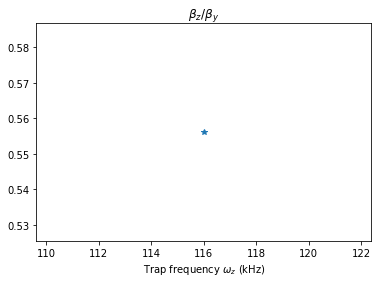

In [26]:
def dN_polarized_pure3b_dt(t, N0, gamma):
    return -0.5*N0**3*gamma*(1+N0**2*gamma*t)**(-3/2)

def getBeta(results, detuning, field_direction, TOF):
    temp = results[results['detuning'] == detuning]
    temp = temp[temp['TOF'] == TOF]
    return temp[temp['field_direction'] == field_direction]['gamma']

results_betaRatio = []
for detuning in ['0.5GHz']:#, '1.5GHz']:
    for TOF in [3]:#, 3]:
        print(detuning, TOF)
        beta_y_init = getBeta(resultsDF_pure3b, detuning, 'By', TOF)
        beta_z_init = getBeta(resultsDF_pure3b, detuning, 'Bz', TOF)
        dt = deltaTime(resultsDF_pure3b, detuning, TOF)
        
        results_By = getReducedResults(resultsDF_pure3b, detuning, 'By', TOF)
        results_Bz = getReducedResults(resultsDF_pure3b, detuning, 'Bz', TOF)
        N0_y, gamma_y = results_By['N0'].iloc[0], results_By['gamma'].iloc[0]
        N0_z, gamma_z = results_Bz['N0'].iloc[0], results_Bz['gamma'].iloc[0]
        
        beta_y = dN_polarized_pure3b_dt(0, N0_y, gamma_y)
        beta_z = dN_polarized_pure3b_dt(0, N0_z, gamma_z)
        
        results_betaRatio += [{'detuning' : detuning,
                        'TOF' : TOF,
                        'betaRatio' : beta_z/beta_y}]

results_betaRatio = pd.DataFrame(results_betaRatio)

results_betaRatio

points05G = results_betaRatio[results_betaRatio['detuning'] == '0.5GHz']['betaRatio']
#points15G = results_betaRatio[results_betaRatio['detuning'] == '1.5GHz']['betaRatio']

plt.figure()
plt.plot([116], points05G, '*')
#plt.plot([96], points15G, '*')
plt.title(r'$\beta_{z}/\beta_{y}$')
plt.xlabel(r'Trap frequency $\omega_{z}$ (kHz)')
plt.show()